
# NVIDIA NIMs with Tool Calling for Agents

This notebook will use a [NVIDIA Llama 3.1 NIM](https://developer.nvidia.com/blog/supercharging-llama-3-1-across-nvidia-platforms/) with tool-calling agent capabilities in generative AI solutions. As mentioned in this [Introductory Blog on LLM Agents](https://developer.nvidia.com/blog/introduction-to-llm-agents/), agents can be described as AI systems that use LLMs to reason through a problem, create a plan to solve the problem, execute the plan with the help of a set of tools, and use memory to store meaningful context of the system state. 

The notebook is designed to provide an intro to merely one of the capabilities of agent systems: **tool calling**. 

**Tools** are interfaces that accept input, execute an action, and then return a result of that action in a structured output according to a pre-defined schema. They often encompass external API calls that the agent can use to perform tasks that go beyond the capabilities of the LLM, but do not have to be external API calls. For example, to get the current weather in San Diego, a weather tool might be used. Or to get the current score of the 49ers game, a generic web search tool or ESPN tool might be used. 

## What is NVIDIA NIM and How do They Support Tool Calling for Agents?
### What is NIM?
NIM supports models across domains like chat, embedding, and re-ranking models 
from the community as well as NVIDIA. These models are optimized by NVIDIA to deliver the best performance on NVIDIA 
accelerated infrastructure and deployed as a NIM, an easy-to-use, prebuilt containers that deploy anywhere using a single 
command on NVIDIA accelerated infrastructure. If you're new to NIMs with LangChain, check out the [documentation](https://python.langchain.com/v0.2/docs/integrations/providers/nvidia/).

Now, NIMs support tool calling, also known as "function calling" for models that have the aforementioned capability. 

This notebook will demonstrate a model that supports function calling, [Llama 3.1 8b-instruct](https://build.nvidia.com/meta/llama-3_1-8b-instruct). 

### What does it mean for NIM to support tool usage?
In order to support tool usage in an agent workflow, first an LLM must be trained to detect when a function should be called and output a structured response like JSON that contains the function to be called and its arguments. 

Next, the model is packaged as a NIM, meaning it's optimized to deliver best performance on NVIDIA accelerated infrastructure and easy to deploy as well as use. This microservice packaging also uses OpenAI compatible APIs, so developers can build world-class generative AI agents with ease.

Let's see how to use tools for agentic applications with LangGraph. 

*Note: lots of the educational content is adapted from https://langchain-ai.github.io/langgraph/concepts/high_level/.*

##  🔨 Tool Usage -- Web Search

Since a LLM does not have access to the most up-to-date information on the Internet, [Tavily Search](https://docs.tavily.com/docs/tavily-api/introduction) acts as a tool to provide a generative AI application with real-time online information.  Tavily is a search engmine that is optimized for AI developers and AI agents. A singular API call abstracts searching, scraping, filtering, and extracting relevant information from online sources. 

We'll enhance our NIM, [Llama 3.1-8b-instruct](https://build.nvidia.com/meta/llama-3_1-8b-instruct), with Tavily search. 

Install pre-requesites. 

In [ ]:
%pip install -U langchain langgraph langchain-nvidia-ai-endpoints langchain-community langchain-openai tavily-python geocoder

If you're using NVIDIA hosted NIMs, you'll need to use an API key which you can setup below. Follow [NVIDIA NIMs LangChain documentation](https://python.langchain.com/v0.2/docs/integrations/chat/nvidia_ai_endpoints/) for more information on accessing and using NIMs. 

In [1]:
import getpass
import os

os.environ["NVIDIA_API_KEY"] = "nvapi-xxx"

Declare your model that supports tool calling. In this example, we use [Llama 3.1-8b-instruct](https://build.nvidia.com/meta/llama-3_1-8b-instruct). 

In [2]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA

llm = ChatNVIDIA(model="meta/llama-3.1-8b-instruct")

Initialize [Tavily Tool](https://python.langchain.com/v0.2/docs/integrations/tools/tavily_search/)

Note that this requires an API key - they have a free tier, but if you don't have one or don't want to create one, you can always ignore this step or use a different tool. 

Once you create your API key, you will need to set it in the environment.

In [3]:
import getpass
import os

os.environ["TAVILY_API_KEY"] = "tvly-xxx"

In [4]:
from langchain_community.tools.tavily_search import TavilySearchResults

# Declare a single tool, Tavily search
tools = [TavilySearchResults(max_results=1)]

We will wrap the tools as a `ToolNode` which will be beneficial to use in LangGraph later.

In [5]:
from langgraph.prebuilt import ToolNode

tool_node = ToolNode(tools)

Let's invoke the tool manually to see the result.

In [6]:
from langchain_core.messages import AIMessage

message_with_single_tool_call = AIMessage(
    content="",
    tool_calls=[
        {
            "name": "tavily_search_results_json",
            "args": {"query": "What's the weather in San Francisco?"},
            "id": "tool_call_id",
            "type": "tool_call",
        }
    ],
)

tool_node.invoke({"messages": [message_with_single_tool_call]})

{'messages': [ToolMessage(content='[{"url": "https://www.weatherapi.com/", "content": "{\'location\': {\'name\': \'San Francisco\', \'region\': \'California\', \'country\': \'United States of America\', \'lat\': 37.78, \'lon\': -122.42, \'tz_id\': \'America/Los_Angeles\', \'localtime_epoch\': 1723495766, \'localtime\': \'2024-08-12 13:49\'}, \'current\': {\'last_updated_epoch\': 1723495500, \'last_updated\': \'2024-08-12 13:45\', \'temp_c\': 16.0, \'temp_f\': 60.8, \'is_day\': 1, \'condition\': {\'text\': \'Sunny\', \'icon\': \'//cdn.weatherapi.com/weather/64x64/day/113.png\', \'code\': 1000}, \'wind_mph\': 12.3, \'wind_kph\': 19.8, \'wind_degree\': 250, \'wind_dir\': \'WSW\', \'pressure_mb\': 1015.0, \'pressure_in\': 29.98, \'precip_mm\': 0.0, \'precip_in\': 0.0, \'humidity\': 75, \'cloud\': 0, \'feelslike_c\': 15.9, \'feelslike_f\': 60.7, \'windchill_c\': 15.9, \'windchill_f\': 60.7, \'heatindex_c\': 16.0, \'heatindex_f\': 60.8, \'dewpoint_c\': 11.5, \'dewpoint_f\': 52.8, \'vis_km\':

Now, let's see how to use the tool with a chat model. This requires binding the tool to the LLM. 

In [7]:
llm_with_tools = llm.bind_tools(tools)

In [8]:
llm_with_tools.invoke("What's the weather in San Francisco?").tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'San Francisco weather today'},
  'id': 'chatcmpl-tool-99f68eb818504801aec450e1cee73b6f',
  'type': 'tool_call'}]

As you can see, the LLM decides that it is best to use the `tavily_search_results_json` tool and that the query is "San Francisco Weather today". Output is structured accordingly.

Let's send this as a message to the ToolNode -- more on this in the next section :) 

In [9]:
tool_node.invoke({"messages": [llm_with_tools.invoke("What's the weather in San Francisco?")]})

{'messages': [ToolMessage(content='[{"url": "https://www.weatherapi.com/", "content": "{\'location\': {\'name\': \'San Francisco\', \'region\': \'California\', \'country\': \'United States of America\', \'lat\': 37.78, \'lon\': -122.42, \'tz_id\': \'America/Los_Angeles\', \'localtime_epoch\': 1723495766, \'localtime\': \'2024-08-12 13:49\'}, \'current\': {\'last_updated_epoch\': 1723495500, \'last_updated\': \'2024-08-12 13:45\', \'temp_c\': 16.0, \'temp_f\': 60.8, \'is_day\': 1, \'condition\': {\'text\': \'Sunny\', \'icon\': \'//cdn.weatherapi.com/weather/64x64/day/113.png\', \'code\': 1000}, \'wind_mph\': 12.3, \'wind_kph\': 19.8, \'wind_degree\': 250, \'wind_dir\': \'WSW\', \'pressure_mb\': 1015.0, \'pressure_in\': 29.98, \'precip_mm\': 0.0, \'precip_in\': 0.0, \'humidity\': 75, \'cloud\': 0, \'feelslike_c\': 15.9, \'feelslike_f\': 60.7, \'windchill_c\': 15.9, \'windchill_f\': 60.7, \'heatindex_c\': 16.0, \'heatindex_f\': 60.8, \'dewpoint_c\': 11.5, \'dewpoint_f\': 52.8, \'vis_km\':

## 🔨 Tool Usage -- Adding on a Custom Tool and Using LangGraph

Let's see how to [define a custom tool](https://python.langchain.com/v0.2/docs/how_to/custom_tools/) for your NIM agent and how it handles multiple tools.  

We'll enhance the NIM with Tavily search with some custom tools to determine a user's current location (based on IP address) and return a latitude and longitude. We will use these tools to have Tavily look up the weather in the user's current location.

In addition, we'll see how to use the `ToolNode` we declared earlier in a graph declared with LangGraph. We'll use an agent that repeatedly calls an LLM deciding which tools to call, the input to those tools, executes/produces output, and then feeds the outputs back to the LLM as observation. When no more tools are needed, the loop ends. 

First, let's create a custom tool to determine a user's location based off IP address. 

In [10]:
import geocoder
from langchain.tools import tool
from typing import Tuple

@tool
def get_current_location() -> list:
    """Return the current location of the user based on IP address"""
    loc = geocoder.ip('me')
    return loc.latlng    

Let's update the tools and the `ToolNode` to use the Tavily tool delcared earlier and also add the `get_current_location` tool.

In [11]:
# Declare two tools: Tavily and custom get_current_location tool.
tools = [TavilySearchResults(max_results=1), get_current_location]
tool_node = ToolNode(tools)

# be sure to bind the updated tools to the LLM!
llm_with_tools = llm.bind_tools(tools)

Let's create a graph! LangGraph models agent workflows as graphs and the behavior of the agent is defined by 3 key pieces:
1) `State`: shared data structure that represents the snapshot of the application. In this example, the state consists of messages.
2) `Nodes`: Python functions that encode the logic of the agents. They receive the state as input and then perform some actions and return an updated State. In this example, the nodes are an agent and tools. 
3) `Edges`: Python functions that determine which Node to execute next based on the State.

A `StateGraph` is the main graph class used and is parameterized to use `MessagesState` as the graph state.

In [12]:
from typing import Literal

from langgraph.graph import StateGraph, MessagesState

# in this graph continue until no more tools
def should_continue(state: MessagesState) -> Literal["tools", "__end__"]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return "__end__"

# call the model on the current messages
def call_model(state: MessagesState):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}


workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# Define edges of the graph
workflow.add_edge("__start__", "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
)


workflow.add_edge("tools", "agent")

# check structure of graph by compiling it
app = workflow.compile()

Let's see a visual representation of the graph. As you can see, the agent will keep calling tools until it's finished.

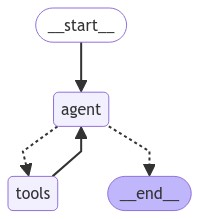

In [13]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

And now let's run the graph in 2 examples! First, we'll try a query that only requires one tool call. Then we'll try a query that requires multiple tool calls.

In [14]:
# example with a single tool call
for chunk in app.stream(
    {"messages": [("human", "What's the weather in San Francisco?")]}, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What's the weather in San Francisco?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (chatcmpl-tool-a266d125e555420f976689051e8d3f5c)
 Call ID: chatcmpl-tool-a266d125e555420f976689051e8d3f5c
  Args:
    query: San Francisco weather
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'San Francisco', 'region': 'California', 'country': 'United States of America', 'lat': 37.78, 'lon': -122.42, 'tz_id': 'America/Los_Angeles', 'localtime_epoch': 1723495766, 'localtime': '2024-08-12 13:49'}, 'current': {'last_updated_epoch': 1723495500, 'last_updated': '2024-08-12 13:45', 'temp_c': 16.0, 'temp_f': 60.8, 'is_day': 1, 'condition': {'text': 'Sunny', 'icon': '//cdn.weatherapi.com/weather/64x64/day/113.png', 

In [16]:
# example with a multiple tool calls
for chunk in app.stream(
    {"messages": [("human", "What's the weather where I currently am?")]}, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What's the weather where I currently am?
================================== Ai Message ==================================
Tool Calls:
  get_current_location (chatcmpl-tool-3de300004d9d42179f8cac2f00a85752)
 Call ID: chatcmpl-tool-3de300004d9d42179f8cac2f00a85752
  Args:
================================= Tool Message =================================
Name: get_current_location

[43.7064, -79.3986]
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (chatcmpl-tool-9b6c5f77fe174bbf8308e0dffa57545c)
 Call ID: chatcmpl-tool-9b6c5f77fe174bbf8308e0dffa57545c
  Args:
    query: weather [43.7064, -79.3986]
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'Toronto', 'region': 'Ontario', 'country': 'Canada', '

We already declared our LLM, so we don't need to redeclare it. However, we do want to update the agent to have the updated tools.

## Conclusion
You've now seen how to use NIMs to do tool calling, an important capability of agents. As mentioned earlier, tools are just one part of agent capabilities, so check out other notebook so see how tools can be used with othe techniques to create agent workflows.

If you're ready to explore more complicated agent workflows, check out [this blog](https://developer.nvidia.com/blog/build-an-agentic-rag-pipeline-with-llama-3-1-and-nvidia-nemo-retriever-nims/) on how to improve your RAG pipeline with agents with Llama 3.1 and NVIDIA NemMo Retriever NIMs.